# Visual speech recognition with neural networks

There are a lot of studies considering speech recognition from visual and audio sources. This application is useful for creating subtitles automatic for videos, where the mouth can be seen.

Our goal is to process different videos, and find out what word was spelled. In our dataset we have different words and for each word we have around 1000 videos.

We ran the script in Google Colaboratory.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# importing necessary libraries
import dlib
import glob
import imageio
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import shutil
import subprocess
import time
from tqdm import tqdm
from matplotlib.patches import Rectangle
from skimage.transform import resize


## Datagenerator

There isn't any implemented datagenerator for video frames in keras but we can write our own video frame datagenerator. It would be useful to create a datagenerator which can work with the model.fit function. This function can use keras.utils.Sequence (or datagenerator) type variables in the x parameter. 

### Video frame datagenerator

The VideoFrameGenerator class derives from the keras.utils.Sequence class. Our class generates batch of frames from the frames directory. Video frames should be classified in classes. The directories have to be the following format:

*   videos/class1/file1/frameimages
*   videos/class1/file2/frameimages
*   videos/class2/file3/frameimages

The frame images are created in the above Dataset block. In the transform parameter we can add data augmentation methods with az ImagDataGenerator type variable.

We need to implement some important functions in our class, because the model.fit function uses them during training.

*   __iter__()
*   __next__()
*   __getitem()__

The class stores only the path to the files. The images are processed during training. During this preprocessing we rescale for normalization and resize the image and if it is needed it is converted to grayscale image. There is a given frame number in the init function, because the frames can only be stored in a numpy array if they have the same length. There are a lot of words with different length and that's why with different frames so we have to pad the frames (sequences) to get the same frame numbers. We use the pad_sequences function with post padding which pads the frames with empty frames (zero padding) at the end. The network will learn that the padding doesn't matter.


            

In [4]:
import keras
import cv2 as cv
import glob
import numpy as np
import os
import random
from tqdm import tqdm
from keras.preprocessing.image import img_to_array
from keras.preprocessing.sequence import pad_sequences

class VideoFrameGenerator(keras.utils.Sequence):
    '''
        Generates video frames from frame directories
    '''
    def __init__(self,
                 from_dir,
                 rescale=1/255.,
                 batch_size=8,
                 shape=(100, 100, 3),
                 nbframe=20,
                 shuffle=False,
                 transform:keras.preprocessing.image.ImageDataGenerator=None,
                 grayscale=False
                ):
        """
        Create a Video Frame Generator with data augmentation.
        
        Arguments:
        - from_dir: path to the data directory where resides video frames
        - rescale: the value for rescaling the images
        - batch_size: number of videos to generate in a step
        - shape: the shape of the result images
        - nbframe: number of frames per video
        - shuffle: flag to shuffle data at start and after each epoch
        - transform: a keras ImageGenerator configured with random transformations
            to apply on each frame
        - grayscale: flag to convert images to grayscale or not
        """

        self.from_dir = from_dir
        self.rescale = rescale
        self.nbframe = nbframe
        self.batch_size = batch_size
        self.target_shape = shape
        self.shuffle = shuffle
        self.transform = transform
        self.grayscale = grayscale
        
        self.classes = []
        self.files = []
        self.class_indices = {}

        self._current = 0
        
        self.__filecount = 0
        self.__get_all_files()

        print("\nTotal data: %d classes for %d files for %s" % (
            len(self.classes),
            len(self.files),
            os.path.basename(self.from_dir)))
    
        
    def __len__(self):
        """ Length of the generator
         It gives the number of loop to do. You can use it as
        `step_per_epoch` or `validation_step` for `model.fit_generator` parameters.
        """
        return self.__filecount//self.batch_size

    def __iter__(self):
      return self

    def __next__(self):
        return self.next()
    
    def next(self):
      """ Return next element"""
      elem = self[self._current]
      self._current += 1
      if self._current == len(self):
          self._current = 0
          self.on_epoch_end()

      return elem


    def __getitem__(self, index):
        """ Generator needed method - return a batch of `batch_size` video frames
        """

        labels = []
        images = []

        # get the next block of files (it contains a batchsize of the video frames)
        frame_dirs = self.files[index*self.batch_size:(index+1)*self.batch_size]

        for dir in frame_dirs:
          # get classname from path
          label_name = self._get_classname(dir)

          # check if class name is valid
          label = np.zeros(len(self.classes))
          if label_name not in self.class_indices.keys():
            print(f'ERROR: {label_name} not in class labels.')
            continue
          
          # get the id of the class
          col = self.class_indices[label_name]
          label[col] = 1.

          # get preprocessed frames for the actual video
          frames = self.__readframe(dir)

          if frames is None:
            continue

          # use data augmentation
          frames = self.__data_aug(frames)
        
          # add the sequence in batch
          images.append(frames)
          labels.append(label)

        return np.array(images), np.array(labels)
    
    def on_epoch_end(self):
        """ When epoch has finished, random shuffle images in memory """

        if self.shuffle:
            random.shuffle(self.files)

    def _get_classname(self, video: str) -> str:
      """ Find classname from video fraem dir path """

      classname = os.path.basename(os.path.dirname(video))
      return classname
    
    def __get_all_files(self):
        """ List and store images path in memory """
        # get classes and sort them in ABC order
        self.classes = glob.glob(os.path.join(self.from_dir, '*'))
        self.classes = sorted([os.path.basename(c) for c in self.classes])

        # create label indexes for classes
        self.class_indices = dict(zip(self.classes, range(len(self.classes))))

        # count all video file dirs
        self.__filecount = len(glob.glob(os.path.join(self.from_dir, '*/*')))
        
        for classname in self.classes:
            # print('\n', classname)

            # list video file dirs for classes
            videos = glob.glob(os.path.join(self.from_dir, classname, '*'))

            self.files += videos

        # shuffle files
        random.shuffle(self.files)
        self.on_epoch_end()
        
    def __readframe(self, frame_dir):
      """Read and preprocess frames from directory"""
      frames = []

      # read frame images
      files = glob.glob(os.path.join(frame_dir, '*'))
      for f in files:
        frame = cv.imread(f)
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        frame = cv.resize(frame, self.target_shape[:2])
        if self.grayscale:
          frame = cv.cvtColor(frame, cv.COLOR_RGB2GRAY) 

        frame = img_to_array(frame) * self.rescale
        frames.append(frame)
      
      if len(frames)==0:
        print("ERROR: not found frames\n")
        return None

      else:
        
        # use padding to create a self.nbframes length of images
        frames = pad_sequences([frames], padding="post", maxlen=self.nbframe, dtype=float, truncating="post")[0]

        # add frames in memory
        if len(frames) == self.nbframe:
            return frames
            
        else:
            print('\n%s has not enough frames ==> %d' % (frame_dir, len(frames)))
            return None
            
    def __data_aug(self, frames):
        """ Make random transformation based on ImageGenerator arguments"""
        T = None
        if self.transform is not None:
          # get random transform from generator
            T = self.transform.get_random_transform(self.target_shape[:2])
        
        result = frames
        if T is not None:
          # apply transformation
          result = [self.transform.apply_transform(frame, T) for frame in frames]

        return np.array(result)

Copy the zip file from drive and unzip it, because training from drive is too slow.

In [5]:
shutil.copyfile('/content/drive/MyDrive/DL_HW/dataset10.zip', '/content/dataset10.zip')

'/content/dataset10.zip'

In [ ]:
!unzip /content/dataset10.zip

In [ ]:
shutil.copyfile('/content/drive/MyDrive/DL_HW/export_100words.zip', '/content/export_100words.zip')

'/content/export_100words.zip'

In [ ]:
!unzip /content/export_100words.zip

Define necessary variables

In [92]:
NBFRAME = 20
TARGET_SIZE = 100
BSIZE = 32
TO_GRAYSCALE = True

TRAIN_DIR = '/content/dataset10/train'
VAL_DIR = '/content/dataset10/val'
TEST_DIR = '/content/dataset10/test'

Use datagenerators for train, validation and test directories

In [94]:
test_gen = VideoFrameGenerator(from_dir = TEST_DIR,
                 rescale=1/255.,
                 batch_size=1,
                 shape=(TARGET_SIZE, TARGET_SIZE, 1 if TO_GRAYSCALE else 3),
                 nbframe=NBFRAME,
                 shuffle=False,
                 grayscale = TO_GRAYSCALE)


Total data: 10 classes for 50 files for test


You can print the class indices to see the labels and their indexes.

In [13]:
print(test_gen.class_indices)

{'ABOUT': 0, 'ABSOLUTELY': 1, 'ANNOUNCED': 2, 'ANYTHING': 3, 'BECAUSE': 4, 'BLACK': 5, 'BORDER': 6, 'CHANGE': 7, 'CHILDREN': 8, 'CLOUD': 9}


## Models

We trained some different models for solving the problem. The results can be visualized in the logs directory with tensorboard.

### ResNet + BidiGRU

This model consists of a frontend part where they use Conv3D layers with pooling and batch normalization to extract low-level features from the sequences of the video frames (grayscale images). After that a ResNet architecture is used to get higher level features. (It uses 2D convolution) The backend of the network consists of bidirectional GRU or LSTM layers. At the end a Dense layer is used with softmax activation for classification. The model can be used with temporal convulation instead of memory cells. Lambda layers are used to integrate tensorflow functions to the network as a layer.

The idea is from the document on the link below:
https://arxiv.org/pdf/1703.04105.pdf

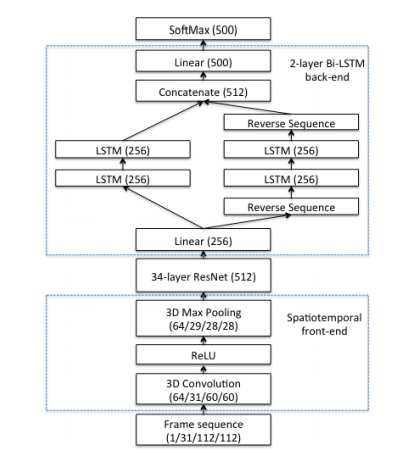

In [14]:
!pip install image-classifiers

     |████████████████████████████████| 51kB 6.8MB/s 


In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, GlobalAveragePooling2D, MaxPooling1D, Lambda, Bidirectional
from tensorflow.keras.layers import MaxPooling3D, ZeroPadding3D, Conv3D, Conv1D, Activation, BatchNormalization, Dropout
from tensorflow.keras import Model, Sequential
from classification_models.keras import Classifiers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2

def GRU(x, hidden_size):

    # in case of GRU add reset_after=True parameter, dropout!!!! 
    out = Bidirectional(keras.layers.GRU(hidden_size, return_sequences=True, 
                                         kernel_initializer='Orthogonal', reset_after=False, 
                                         name='gru1'), merge_mode='concat')(x)
    out = Bidirectional(keras.layers.GRU(hidden_size, return_sequences=False, 
                                         kernel_initializer='Orthogonal', reset_after=False, 
                                         name='gru2'), merge_mode='concat')(out)
    
    return out

def create_Resnet_GRU(mode, activation, dropout, filterdim, inputDim, hiddenDim, nClasses, frameLen, input_shape=(NBFRAME,TARGET_SIZE,TARGET_SIZE,1), every_frame=True):
  # images need to converted to grayscale

  # frontend part of the network
  frontend3D = Sequential([
                ZeroPadding3D(padding=(2, 3, 3)),
                Conv3D(filterdim, kernel_size=(5, 7, 7), strides=(1, 2, 2), padding='valid', kernel_regularizer=l2(1e-2), use_bias=False),
                BatchNormalization(),
                Activation(activation),
                ZeroPadding3D(padding=((0, 4, 8))),
                MaxPooling3D(pool_size=(1, 2, 3), strides=(1, 1, 2))
                ])
  
  # for temporal convolution
  backend_conv1 = Sequential([
            Conv1D(2*inputDim, 5, strides=2, use_bias=False),
            BatchNormalization(),
            Activation(activation),
            MaxPooling1D(2, 2),
            Conv1D(4*inputDim, 5, strides=2, use_bias=False),
            BatchNormalization(),
            Activation(activation)
            ])
  
  # for temporal convolution
  backend_conv2 = Sequential([
            Dense(inputDim),
            BatchNormalization(),
            Activation(activation),
            Dense(nClasses)
            ])
  
  # -----------------------------------------------------------------
  # creating the model
  input_frames = Input(shape=input_shape, name='frames_input')
  x = frontend3D(input_frames)

  # reshape output for the input of Resnet 2D
  x = Lambda(lambda x : tf.reshape(x, [-1, int(x.shape[2]), int(x.shape[3]), int(x.shape[4])]), name='lambda2')(x)

  channels = int(x.shape[-1])
  
  # get resnet model
  ResNet18, preprocess_input = Classifiers.get('resnet18')
  resnet18 = ResNet18((None, None, channels), weights=None, include_top=False)

  x = resnet18(x)
  # x = MobileNetV2(
  #     input_shape=(None, None, channels),
  #     include_top=False,
  #     weights=None)(x)

  # Flatten with global average pooling  for the input of the dense layer
  x = GlobalAveragePooling2D(name='global_avgpool_resnet')(x)
  x = Dense(inputDim, name='dense_resnet', kernel_regularizer=l2(1e-2))(x)
  x = Dropout(dropout)(x)
  x = BatchNormalization(name='bn_resnet')(x)

  if mode == 'temporalConv':
    x = Lambda(lambda x : tf.reshape(x, [-1, frameLen, inputDim]), name='lambda3')(x)   #x.view(-1, frameLen, inputDim)

    x = Lambda(lambda x : tf.transpose(x, [0, 2, 1]), name='lambda4')(x)   #x.transpose(1, 2)
    x = backend_conv1(x)
    x = Lambda(lambda x : tf.reduce_mean(x, 2), name='lambda5')(x)
    x = backend_conv2(x)

  elif mode == 'backendGRU' or mode == 'finetuneGRU':
    x = Lambda(lambda x : tf.reshape(x, [-1, frameLen, inputDim]), name='lambda6')(x)    #x.view(-1, frameLen, inputDim)

    # add memory cells to the network (GRU or LSTM)
    x = GRU(x, hiddenDim)

    # add the dropout layer and the last Dense layer for classification
    if every_frame:
      x = Dropout(dropout)(x)
      x = Dense(nClasses, activation='softmax')(x)  # predictions based on every time step
    else:
      x = Dropout(dropout)(x)
      x = Dense(nClasses, activation='softmax')(x[:, -1, :])  # predictions based on last time-step

  # construct the model
  model = Model(inputs=input_frames, outputs=x)

  return model


Create the model with the written functions above. After that the model is compiled with SGD optimizer and categorical crossentropy loss function.

In [105]:
CLASS_NUM = len(test_gen.class_indices.keys())
print('class number: ',CLASS_NUM)

# call the model creator function
model = create_Resnet_GRU(mode='backendGRU', activation='elu', 
                          dropout=0.2, filterdim=32, inputDim=32, 
                          hiddenDim=20, nClasses=CLASS_NUM, 
                          frameLen=NBFRAME, every_frame=True)


class number:  10


The network structure:

In [ ]:
model.summary()

## Testing the models

In [110]:
mpath = '/content/drive/MyDrive/DL_HW/models/resnet18_backendgru_valshuffleFalse_bsizeval1_adam_elu_regularizer_dropout2_dataaug_1536.hdf5'
model.load_weights(mpath)

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [113]:
def predict_on_test_set(test_set, model):

  # execute prediction with the given model
  predicts = model.predict(test_set, verbose = True, workers = 4)

  # get the prediction with the highest confidence
  top_predicts = np.argmax(predicts, axis=1)

  # get the labels from the path of the files
  groundtruth_labels = [x.rsplit('/',2)[1] for x in test_set.files]
  # get the index of the label names
  gt_index = [test_set.class_indices[l] for l in groundtruth_labels]

  # calculate accuracy and show confusion matrix
  print(f"test accuracy: {accuracy_score(gt_index, top_predicts)}")
  print("Confusion matrix: ")
  conf=confusion_matrix(gt_index, top_predicts)
  # print(conf)

  # show the matrix on heatmap
  sns.heatmap(conf, annot=True, fmt='d', vmax=5)

50/50 [==============================] - 1s 23ms/step
test accuracy: 0.58
Confusion matrix: 


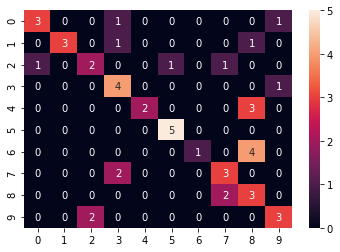

In [114]:
predict_on_test_set(test_gen, model)

Detailed results for every videos

In [116]:
import pandas as pd

predictions = model.predict(test_gen)
index = np.argmax(predictions, axis=1)  # the predicted id of the labels for the images
values = np.max(predictions, axis=1)
labels = [x.rsplit('/',2)[1] for x in test_gen.files] # real labels of the FILES

column_names = ['Video path', 'Real word', 'Prediction', 'Confidence', 'Is Matching']
rows = []

for i,label_id in enumerate(index):
  predicted_label = list(test_gen.class_indices.keys())[label_id]    # class_indices starts at 0
  real_label = labels[i]
  is_match = predicted_label == real_label
  data = [test_gen.files[i].rsplit('/',1)[1], real_label, predicted_label, values[i], is_match]
  rows.append(data)

df = pd.DataFrame(rows,columns=column_names)
df = df.sort_values('Video path')

df

,Video path,Real word,Prediction,Confidence,Is Matching
10,ABOUT_00005,ABOUT,ABOUT,0.665974,True
13,ABOUT_00009,ABOUT,CLOUD,0.641089,False
4,ABOUT_00035,ABOUT,ABOUT,0.812749,True
9,ABOUT_00038,ABOUT,ABOUT,0.508506,True
27,ABOUT_00043,ABOUT,ANYTHING,0.341594,False
46,ABSOLUTELY_00010,ABSOLUTELY,ABSOLUTELY,0.318364,True
18,ABSOLUTELY_00033,ABSOLUTELY,ABSOLUTELY,0.738237,True
1,ABSOLUTELY_00035,ABSOLUTELY,ANYTHING,0.648926,False
33,ABSOLUTELY_00041,ABSOLUTELY,CHILDREN,0.772104,False
41,ABSOLUTELY_00050,ABSOLUTELY,ABSOLUTELY,0.400032,True
